In [42]:
# 使用 python-dotenv 加载 .env 文件
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

# 加载当前目录下的 .env 文件
load_dotenv(override=True)

# 获取环境变量
api_key = os.getenv("API_KEY")
base_url = os.getenv("BASE_URL")
tavily_key = os.getenv("TAVILY_API_KEY")
model_name = os.getenv("MODEL_NAME")
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"


# 初始化模型
model = ChatOpenAI(
    base_url=base_url,
    model=model_name,
    api_key=api_key,
    temperature=1,
)

In [43]:
# plan 节点
from pydantic import BaseModel, Field
from typing import List
from langchain.messages import HumanMessage, SystemMessage


class Plan(BaseModel):
    """执行计划"""

    steps: List[str] = Field(description="要遵循的不同步骤，应按顺序排列")


planner = model.with_structured_output(Plan)

# response = planner.invoke(
#     [
#         SystemMessage(content=plan_sys_prompt),
#         HumanMessage(content=user_query),
#     ],
# )

# for chunk in stream:
#     print(chunk, end="")

# print("计划：", response)

In [44]:
# plan execute 节点
# 初始化 Tavily 搜索工具
from langchain_tavily import TavilySearch
from prompts import get_execute_prompt

tavily_search = TavilySearch(
    max_results=5,
    topic="general",
)

# 天气工具
from langchain.tools import tool


@tool
def get_weather(city: str) -> str:
    """获取指定城市的天气信息
    Args:
        city (str): 城市名称
    """
    # 这里可以集成实际的天气API调用
    return f"{city}的天气是晴朗，温度25摄氏度。"


from langchain.agents import create_agent

executor = create_agent(
    tools=[tavily_search, get_weather],
    model=model,
)

# user_query = "去网上查一下2025年英雄联盟S15总决赛在哪里举办？"


# for token, metadata in react_agent.stream(
#     {
#         "messages": [
#             {"role": "system", "content": get_execute_prompt(user_query,)},
#             {"role": "user", "content": user_query},
#         ]
#     },
#     stream_mode="messages",
# ):
#     # print(token)
#     # print("\n")
#     content = token.content
#     if content:
#         print(content, end="")
# elif chunk.tool_calls:
#     print(f"Calling tools: {[tc['name'] for tc in latest_message.tool_calls]}")

In [45]:
# replan
from typing import Literal, Optional


class Replan(BaseModel):
    """重规划者的决策结果"""

    status: Literal["done", "continue"] = Field(
        description="如果是 'done'，表示任务已完成。如果是 'continue'，表示需要执行新计划。"
    )
    new_plan: Optional[List[str]] = Field(
        default=None,
        description="如果 status 是 'continue'，这里必须包含剩余的、更新后的步骤列表。",
    )
    final_response: Optional[str] = Field(
        default=None,
        description="如果 status 是 'done'，这里必须包含回答用户问题的最终完整回复。",
    )


replaner = model.with_structured_output(Replan)

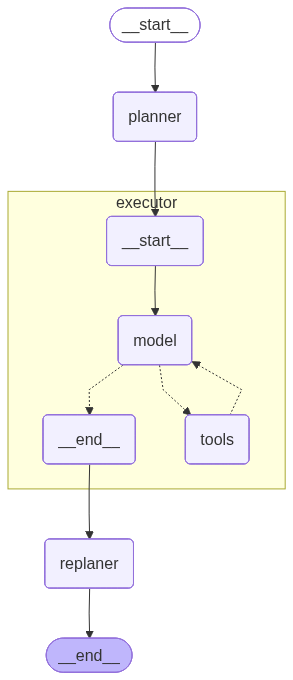

In [46]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict
from prompts import get_execute_prompt, get_replan_prompt, get_plan_prompt


class PlanExecuteAgentState(TypedDict):
    input: str
    steps: List[str]  # 当前要执行的步骤
    past_steps: Annotated[
        List[Tuple], operator.add
    ]  # 已经执行了的步骤 [step,result]元组
    response: str


# plan节点
def plan_node(state: PlanExecuteAgentState):
    result = planner.invoke(
        [SystemMessage(content=get_plan_prompt()), HumanMessage(content=state["input"])]
    )

    return {"steps": result.steps}


# execute节点 只复杂执行某一个步骤的任务
def execute_node(state: PlanExecuteAgentState):
    # 首先拿到当前的步骤
    current_plan = state["steps"][0]
    # 拿到之前执行完了的步骤和结果
    history_steps = "暂无历史记录(这是第一步)"

    if state["past_steps"]:
        history_steps = "\n".join(
            f"步骤:{step}\n结果:{result}\n" for step, result in state["past_steps"]
        )
    # 构造消息列表
    message_template = get_execute_prompt(state["input"], current_plan, history_steps)
    messages = [
        SystemMessage(content=message_template["system"]),
        HumanMessage(content=message_template["human"]),
    ]
    # 调用执行当前节点
    response = executor.invoke(input={"messages": messages})

    return {"past_steps": [(current_plan, response["messages"][-1].content)]}


# replan 节点
def replan_node(state: PlanExecuteAgentState):
    # 拿到所有还没执行的步骤
    current_plan_list = "无"

    if state["steps"]:
        current_plan_list = "".join(f"{step}," for step in state["steps"])

    # 拿到之前执行完了的步骤和结果
    history_steps = "暂无历史记录"

    if state["past_steps"]:
        history_steps = "\n".join(
            f"步骤:{step}\n结果:{result}\n" for step, result in state["past_steps"]
        )

    messages_template = get_replan_prompt(
        state["input"], current_plan_list, history_steps
    )

    # 消息列表
    messages = [
        SystemMessage(content=messages_template["system"]),
        HumanMessage(content=messages_template["human"]),
    ]

    result = replaner.invoke(messages)

    print(result, "replaner")

    if result.status == "done":
        return {"steps": [], "response": result.final_response}
    else:
        return {"steps": result.new_plan}


# langgraph图表创建
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(PlanExecuteAgentState)

workflow.add_node("planner", plan_node)

workflow.add_node("executor", execute_node)

workflow.add_node("replaner", replan_node)

workflow.add_edge(START, "planner")

workflow.add_edge("planner", "executor")

workflow.add_edge("executor", "replaner")


# 判断是否执行步骤还是结束
def should_end(state: PlanExecuteAgentState):
    if "response" in state and state["response"]:
        return END
    else:
        return "executor"


workflow.add_conditional_edges("replaner", should_end)

app = workflow.compile()

from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [47]:
inputs = {"input": "2025年英雄联盟冠军战队是哪个国家的？"}

for event in app.stream(inputs, stream_mode=["messages", "updates"]):
    print(event)

('messages', (AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--46500ec7-4ed4-4ef8-a475-2e0c40ff8e37'), {'langgraph_step': 1, 'langgraph_node': 'planner', 'langgraph_triggers': ('branch:to:planner',), 'langgraph_path': ('__pregel_pull', 'planner'), 'langgraph_checkpoint_ns': 'planner:80af46f5-80c9-49ed-cc1e-09732a93d195', 'checkpoint_ns': 'planner:80af46f5-80c9-49ed-cc1e-09732a93d195', 'ls_provider': 'openai', 'ls_model_name': 'qwen3-max', 'ls_model_type': 'chat', 'ls_temperature': 1.0}))
('messages', (AIMessageChunk(content='{\n', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--46500ec7-4ed4-4ef8-a475-2e0c40ff8e37'), {'langgraph_step': 1, 'langgraph_node': 'planner', 'langgraph_triggers': ('branch:to:planner',), 'langgraph_path': ('__pregel_pull', 'planner'), 'langgraph_checkpoint_ns': 'planner:80af46f5-80c9-49ed-cc1e-09732a93d195', 'checkpoint_ns': 'planner:80af46f5-80c9-49ed-cc1e-09732a93d19